# **Irene Dovichi** 
## Midterm 2 - Assignment 3
Implement from scratch an RBM and apply it to DSET3. The RBM should be implemented fully by you (both CD-1 training and inference steps) but you are free to use library functions for the rest (e.g. image loading and management, etc.).

1. Train an RBM with a number of hidden neurons selected by you (single layer) on the MNIST data (use the training set split provided by the website).

2. Use the trained RBM to encode a selection of test images (e.g. using one per digit type) using the corresponding activation of the hidden neurons.

3. Train a simple classifier (e.g. any simple classifier in scikit) to recognize the MNIST digits using as inputs their encoding obtained at step 2. Use the standard training/test split. Show a performance metric of your choice in the presentation/handout.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import idx2numpy
from tqdm import tqdm

## Dataset Loading

In [2]:
dataset_folder = 'mnist_db/'

# Load train and test images
train_images = idx2numpy.convert_from_file(os.path.join(dataset_folder, 'train-images-idx3-ubyte'))
test_images = idx2numpy.convert_from_file(os.path.join(dataset_folder, 't10k-images-idx3-ubyte'))

# Load train and test labels
train_labels = idx2numpy.convert_from_file(os.path.join(dataset_folder, 'train-labels-idx1-ubyte'))
test_labels = idx2numpy.convert_from_file(os.path.join(dataset_folder, 't10k-labels-idx1-ubyte'))

Image shape: (28, 28)
Pixel value range: 0 - 255
Label: 5


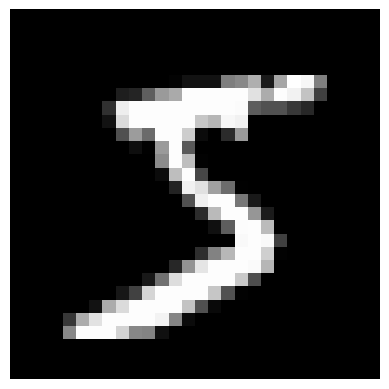

In [3]:
# Print the first image in the train set
first_image = train_images[0]
first_label = train_labels[0]

# Print the shape of the image
print("Image shape:", first_image.shape)

# Print the ranges of pixel values
print("Pixel value range:", first_image.min(), "-", first_image.max())

# Print the label of the image
print("Label:", first_label)

plt.imshow(first_image.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()


### Data Preprocessing

In [4]:
# Normalize pixel values
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

# Binarize the images
threshold = 0.5
train_images_b = np.where(train_images > threshold, 1, 0)
test_images_b = np.where(test_images > threshold, 1, 0)

# Reshape to 1D array
train_images_b = train_images_b.reshape(-1, 28*28)
test_images_b = test_images_b.reshape(-1, 28*28)

Image shape: (784,)
Pixel value range: 0 - 1


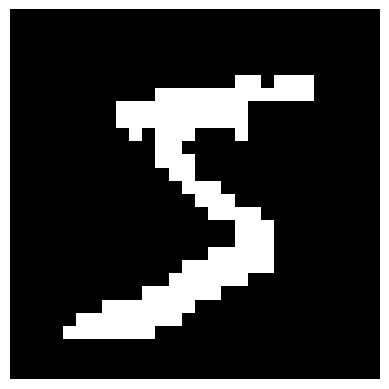

In [5]:
# See the change in the first image of the train set
first_image = train_images_b[0]

# Print the shape of the image
print("Image shape:", first_image.shape)

# Print the ranges of pixel values
print("Pixel value range:", first_image.min(), "-", first_image.max())

plt.imshow(first_image.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()

## RBM Implementation 

In [ ]:
class RBM:
    def __init__(self, visible_units, hidden_units):
        self.v = visible_units
        self.h = hidden_units
        # Initialize weights to small random values taken from 0 mean gaussian with standard deviation 0.01
        self.W = np.random.randn(self.h, self.v) * 0.01
        # Initialize biases of visible units to log(p_i/(1-p_i)) where p_i is the proportion of training data where unit i is on
        self.bv = np.log((np.mean(self.train_images, axis=0) + 1e-5) / (1 - np.mean(self.train_images, axis=0) + 1e-5))
        # Initialize biases of hidden units to zero
        self.bh = np.zeros(self.h)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def train(self, dataset, learning_rate, epochs, batch_size): 
        num_batches = len(dataset) // batch_size
        remainder = len(dataset) % batch_size

        for epoch in tqdm(range(epochs)):
            for i in range(num_batches):
                batch = dataset[i * batch_size : (i + 1) * batch_size]

                ## Compute wake part
                hidden_prob = self.sigmoid(np.dot(batch, self.W.T) + self.bh)
                wake = np.dot(hidden_prob.T, batch)

                ## Compute dream part
                # When the hidden units are being driven by the data, always use stochastic binary states
                hidden_states = np.random.rand(batch_size, self.h) < hidden_prob
                recon_prob = self.sigmoid(np.dot(hidden_states, self.W) + self.bv)
                # When they are being driven by reconstructions, always use probabilities without sampling
                recon_states = recon_prob
                hidden_prob_rec = self.sigmoid(np.dot(recon_states, self.W.T) + self.bh)
                dream = np.dot(hidden_prob_rec.T, recon_states)

                ## Reconstruction error

                ## CD-1 update
                self.W += learning_rate * (wake - dream) / batch_size
                self.bv += learning_rate * (batch.sum(axis=0) - recon_states.sum(axis=0)) / batch_size
                self.bh += learning_rate * (hidden_prob.sum(axis=0) - hidden_prob_rec.sum(axis=0)) / batch_size

            if remainder > 0:
                batch = dataset[num_batches * batch_size :]
                # Compute wake part

                # Compute dream part

                # Reconstruction error

                # CD-1 update


In [6]:
# prova
def sigmoid(x):
        return 1 / (1 + np.exp(-x))

n_h = 50
n_v = 784
batch_size = 100
W = np.random.randn(n_h, n_v) * 0.01
bv = np.log((np.mean(train_images_b, axis=0) + 1e-5) / (1 - np.mean(train_images_b, axis=0) + 1e-5))
bh = np.zeros(n_h)
batch1 = train_images_b[:batch_size]
hidden_prob = sigmoid(np.dot(batch1, W.T) + bh)

print(batch1.shape, hidden_prob.shape)

(100, 784) (100, 50)


In [7]:
wake1 = np.dot(hidden_prob.T, batch1)
print(wake1.shape)

(50, 784)


In [9]:
hidden_states = np.random.rand(batch_size, n_h) < hidden_prob
hidden_states.shape

(100, 50)

In [13]:
hidden_states

array([[ True,  True, False, ...,  True,  True,  True],
       [False,  True, False, ..., False, False, False],
       [False,  True, False, ...,  True,  True, False],
       ...,
       [ True, False, False, ...,  True, False,  True],
       [False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True, False, False]])

In [11]:
np.dot(hidden_states, W).shape

(100, 784)

In [12]:
recon_prob = sigmoid(np.dot(hidden_states, W) + bv)
recon_prob.shape

(100, 784)

In [15]:
recon_states = recon_prob
recon_states

array([[9.73114972e-06, 1.03975047e-05, 1.02782618e-05, ...,
        1.00284984e-05, 9.54827570e-06, 9.72878772e-06],
       [9.71218015e-06, 1.03964442e-05, 1.00670724e-05, ...,
        9.25572268e-06, 9.98110361e-06, 1.05498963e-05],
       [9.55575254e-06, 1.04883037e-05, 1.02606808e-05, ...,
        9.98852768e-06, 9.43289270e-06, 9.70631367e-06],
       ...,
       [9.33826615e-06, 9.93787980e-06, 1.01352116e-05, ...,
        9.86815736e-06, 9.67067348e-06, 9.58837394e-06],
       [9.19054288e-06, 1.00322682e-05, 9.86642423e-06, ...,
        9.73218291e-06, 9.30759026e-06, 1.01832358e-05],
       [9.60791087e-06, 1.00354797e-05, 1.01270347e-05, ...,
        9.10629279e-06, 1.00687394e-05, 9.86467847e-06]])

In [16]:
np.dot(recon_states, W.T).shape

(100, 50)

In [17]:
hidden_prob_rec = sigmoid(np.dot(recon_states, W.T) + bh)
hidden_prob_rec.shape

(100, 50)

In [18]:
dream = np.dot(hidden_prob_rec.T, recon_states)
dream.shape

(50, 784)

In [30]:
# sum batch1 so that i get a vector of shape (784,)
batch1.sum(axis=0).shape

(784,)

In [31]:
recon_states.sum(axis=0).shape

(784,)

In [32]:
bv_prova1 = bv + 0.1 * (batch1.sum(axis=0) - recon_states.sum(axis=0)) / batch_size
bv_prova1.shape

(784,)

In [20]:
batch1.shape, recon_states.shape, bv.shape

((100, 784), (100, 784), (784,))

In [35]:
bv_prova2 = bv + 0.1 * np.mean(batch1 - recon_states, axis=0)
bv_prova2.shape

(784,)

In [36]:
bv_prova1 == bv_prova2

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

## RBM Training Phase

In [ ]:
#TODO: provare senza binarizzazione (usare train_images e test_images al posto di train/test_images_b --> fare il reshape a 1D vector)

## Encoding Phase

## Classification Phase

## Personal Considerations